In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def load_from(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj


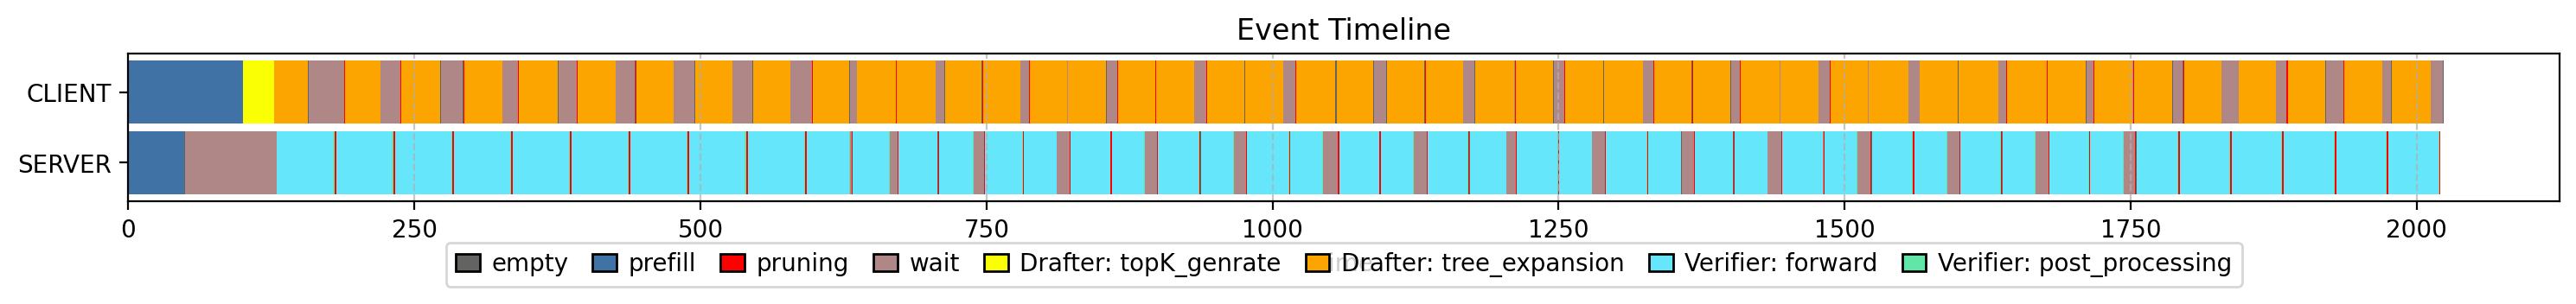

In [14]:
event_type_to_color = {
    'empty': '#636362',
    'prefill': '#4072A6',
    'pruning': 'red',
    'wait': '#b08787',
    # drafter client
    'Drafter: topK_genrate': '#fbff03',
    'Drafter: tree_expansion': '#fca400',
    # verifier server
    'Verifier: forward': '#66e6fa',
    'Verifier: post_processing': '#61E6A8',
}

def get_event_type(event_name: str):
    for event_type in event_type_to_color.keys():
        if event_type in event_name:
            return event_type
    raise ValueError(f'Unknown event: {event_name}')


def get_plot_data(records):
    timestamps = records['timestamp']
    events = records['events']

    assert len(timestamps) == len(events)* 2
    
    timestamps = np.asarray(timestamps) * 1000  # s -> ms
    timestamps -= timestamps[0]  # minus the start time

    start = timestamps[0]
    assert start == 0.0

    timestamps = timestamps[1:-1]  # remove the most outside record
    events = events[1:]

    intervals = []
    prev_time = 0

    for i, event in enumerate(events):
        start = timestamps[2 * i]
        end = timestamps[2 * i + 1]
        intervals.append((start, end))
        
    segments = []
    labels = []

    prev_time = 0
    for i, (start, end) in enumerate(intervals):
        if start > prev_time:
            segments.append((prev_time, start - prev_time))
            labels.append('empty')

        labels.append(get_event_type(events[i]))
        segments.append((start, end - start))

        prev_time = end

    lefts = [seg[0] for seg in segments]
    widths = [seg[1] for seg in segments]
    colors = [event_type_to_color[label] for label in labels]

    return lefts, widths, colors, labels


def show_timestamps(time_str):

    datas = []
    roles = ['SERVER', 'CLIENT']
    for role in roles:
        fname = f'{time_str}-{role}.rec'
        records = load_from(fname)[0]

        datas.append(get_plot_data(records))

    fig, ax = plt.subplots(figsize=(15, 2), dpi=200)

    y_positions = list(range(len(roles)))
    y_labels = roles

    for i, (lefts, widths, colors, labels) in enumerate(datas):
        ax.barh(i, widths, left=lefts, height=0.9,
                color=colors, edgecolor='none', label=labels)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Time")
    ax.set_title("Event Timeline")

    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=event_type_to_color[key], edgecolor='black', label=key)
        for key in event_type_to_color
    ]
    ax.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),  # 调整 y 坐标向下移动
        ncol=len(legend_elements),  # 所有图例项排成一行
        frameon=True,
        fontsize=10,
        columnspacing=1.0,  # 调整列间距
        handlelength=1.0,   # 图例图标长度
        handletextpad=0.5,  # 图例图标与文本之间的间距
        borderaxespad=0.5,  # 图例与图表边界的间距
    )
    # ax.legend(loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)


    plt.tight_layout()
    current_dpi = fig.get_dpi()
    # print(f"当前图像的 DPI: {current_dpi}")
    plt.savefig(f'{time_str}-timeline.pdf')
    plt.show()
            

show_timestamps('records/' + '11-17-22-10')
